<a href="https://colab.research.google.com/github/Lutris98/PersonalProject/blob/main/2.Visualization/Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!pip install beautifulsoup4 
!pip install requests
!pip install mplfinance

In [75]:
from bs4 import BeautifulSoup 
import requests 

In [76]:
url='https://finance.naver.com/item/sise_day.nhn?code=066570'
headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36'}
lgresponse=requests.get(url, headers = headers).text

In [77]:
html=BeautifulSoup(lgresponse,'lxml') 
pgrr=html.find('td',class_='pgRR')
s=str(pgrr.a['href']).split('=')
last_page=s[-1] 

In [78]:
import pandas as pd #실제 스크레이핑엔 requests로 만든 response객체를 read_html해서 읽어옴(beautifulsoup는 찾기만)
lg_df=pd.DataFrame()
for page in range(1, int(last_page)+1): 
  page_url='{0}&page={1}'.format(url,page) 
  lgresponse=requests.get(page_url, headers = headers).text
  lg_df=lg_df.append(pd.read_html(lgresponse,header=0)[0]) 
lg_df=lg_df.dropna()
lg_df=lg_df.rename(columns={'날짜':'Date','시가':'Open','고가':'High','저가':'Low','종가':'Close','거래량':'Volume'}) #mpf에 맞게 OHLCV만 남기고 지움(날짜는 잠시 살려둠)
lg_df.index=pd.to_datetime(lg_df['Date']) #모든 분석에서 index가 datetime형식이어야함
lg_df=lg_df[['Open','High','Low','Close','Volume']]  
lg_df.sort_index(ascending=True,inplace=True) #추후분석에서는 아래가 높게 #value가 아니라 인덱스임

#1.차트분석

##1)캔들차트

In [79]:
candle_df=lg_df.iloc[-30:-1] #candle은 기간너무 길게 잡으면 가시성이 떨어지니깐 
candle_df.sort_index(ascending=False,inplace=True) #candle은 위가 높게

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


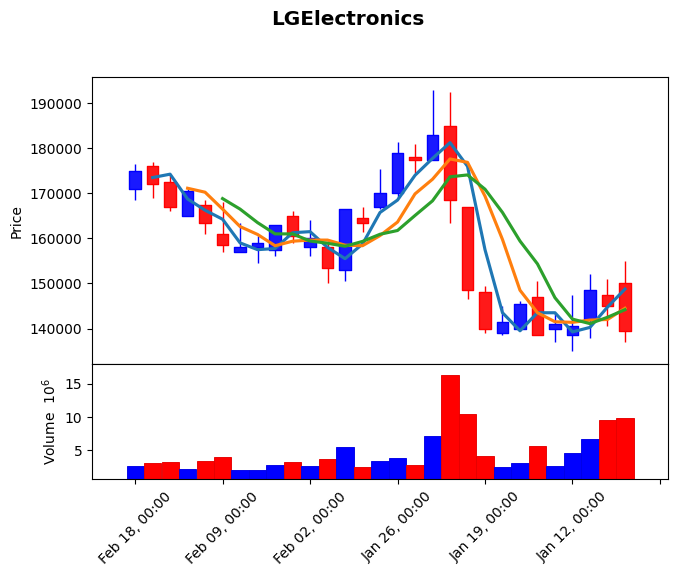

In [80]:
import mplfinance as mpf
kwargs=dict(type='candle',mav=(2,4,6),volume=True,title='LGElectronics',ylabel='Price') #한국어 지원 안됨ㅠ
mc=mpf.make_marketcolors(up='r',down='b',inherit=True) 
s=mpf.make_mpf_style(marketcolors=mc)
mpf.plot(candle_df,**kwargs,style=s)

##2)누적 일간변동률(cumulative DPC) 차트

In [81]:
url='https://finance.naver.com/item/sise_day.nhn?code=005930'
smresponse=requests.get(url, headers = headers).text
html=BeautifulSoup(smresponse,'lxml') 
pgrr=html.find('td',class_='pgRR')
s=str(pgrr.a['href']).split('=')
last_page=s[-1] 
import pandas as pd
sm_df=pd.DataFrame()
for page in range(1, int(last_page)+1): 
  page_url='{0}&page={1}'.format(url,page) 
  smresponse=requests.get(page_url, headers = headers).text
  sm_df=sm_df.append(pd.read_html(smresponse,header=0)[0]) 
sm_df=sm_df.dropna()

In [82]:
sm_df=sm_df.rename(columns={'날짜':'Date','시가':'Open','고가':'High','저가':'Low','종가':'Close','거래량':'Volume'}) 
sm_df.index=pd.to_datetime(sm_df['Date']) 
sm_df=sm_df[['Open','High','Low','Close','Volume']]  
sm_df.sort_index(inplace=True) #아래가 높음 #inplace필수

In [83]:
lg_df=lg_df.iloc[-251:-1] #연중 평일은 250일 정도 #행기준 인덱싱은 쉼표필요없음
lg_dpc=(lg_df['Close']/lg_df['Close'].shift(1)-1)*100 #당연히 어제것을 많이 쓰니깐(특정 인덱스기준 값이 아래로 간다)
lg_dpc.iloc[0]=0 #이제 인덱스만으로 못쓰니깐 #초깃값 일치
lg_dpc_cs=lg_dpc.cumsum()
sm_df=sm_df.iloc[-251:-1]
sm_dpc=(sm_df['Close']/sm_df['Close'].shift(1)-1)*100
sm_dpc.iloc[0]=0
sm_dpc_cs=sm_dpc.cumsum()

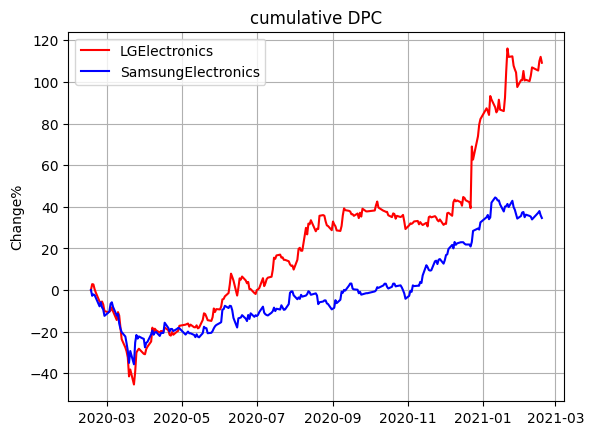

In [84]:
import matplotlib.pyplot as plt
plt.plot(lg_df.index,lg_dpc_cs,'r',label='LGElectronics') #색과 레이블명까지
plt.plot(sm_df.index,sm_dpc_cs,'b',label='SamsungElectronics')
plt.title('cumulative DPC')
plt.ylabel('Change%')
plt.legend(loc='best') #이 두개는 그냥 기본 값
plt.grid(True)

##3)최대손실폭(max Drawdown) 차트

In [85]:
peak=lg_df['Close'].rolling(30,min_periods=1).max() #3개 다 series형식
dd=lg_df['Close']/peak
maxdd=dd.rolling(30,min_periods=1).min()

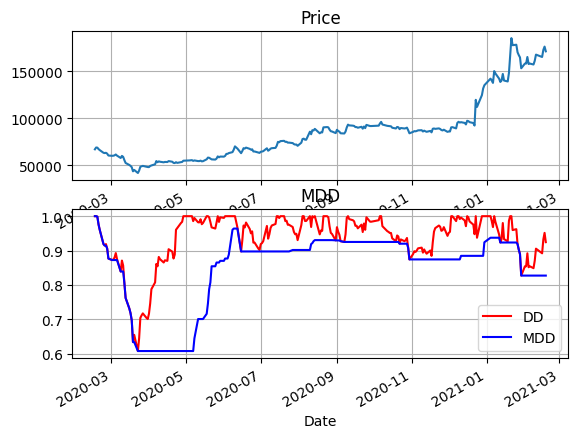

In [86]:
plt.subplot(2,1,1) #훨씬 편함
lg_df.Close.plot(title='Price',grid=True)
plt.subplot(2,1,2)
dd.plot(c='red',label='DD',grid=True,legend=True)
maxdd.plot(c='blue',label='MDD',title='MDD',grid=True,legend=True)
plt.show()

#2.트레이딩 전략 구현<br>

In [87]:
from google.colab import drive
drive.mount('/content/gdrive')
df=pd.read_csv('/content/gdrive/MyDrive/Dataset/tempdb.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [88]:
df.index=sm_df.index

In [89]:
df

,셀트리온,삼성전자,LG전자,카카오
Date,,,,
2020-02-17,178500.0,60700.0,67100.0,179000.0
2020-02-18,181000.0,61800.0,67000.0,180000.0
2020-02-19,186000.0,61500.0,67000.0,180500.0
2020-02-20,184500.0,59800.0,68900.0,182000.0
2020-02-21,181500.0,60200.0,68800.0,190000.0
...,...,...,...,...
2021-02-10,336000.0,83000.0,157000.0,457000.0
2021-02-15,328000.0,82700.0,161000.0,461000.0
2021-02-16,332000.0,81600.0,167500.0,489500.0


##1)샤프지수(효율적 포트폴리오)
이론적 중요성이 큼<br>
단순가격에서 리스크랑 수익뽑아내는 게 핵심<br>

In [90]:
daily_ret=df.pct_change() #dpc가 아예 판다스 내장함수로 구현되어있음
daily_ret.iloc[0]=daily_ret.iloc[1]
daily_cov=daily_ret.cov() #공분산 처음써봄
annual_ret=daily_ret.mean()*250 #annual값이 필요했던 것
annual_cov=daily_cov*250 
port_ret=[] 
port_risk=[]
port_weights=[]
port_sharpe=[]

In [91]:
import numpy as np
for _ in range(20000):
  weights=np.random.random(4) #np패키지속 random모듈속 random함수
  weights=weights/np.sum(weights) #난수가 범위가 없으니깐
  returns=np.dot(weights,annual_ret) 
  risk=np.sqrt(np.dot(weights.T,np.dot(annual_cov,weights))) #포트폴리오 리스크공식(이론상과 약간다른가?) 
  sharpe=(returns-0.005)/risk #기준금리적용
  port_ret.append(returns)
  port_risk.append(risk)
  port_weights.append(weights)
  port_sharpe.append(sharpe)
portfolio={'Return':port_ret,'Risk':port_risk,'Sharpe':port_sharpe} #딕셔너리는 굉장히 애용되는 자료형이구나
stocks=['셀트리온','LG전자','삼성전자','카카오']
for i,s in enumerate(stocks): #인덱스가 앞임
  portfolio[s]=[weight[i] for weight in port_weights] #딕셔너리 입력을 이렇게도 가능하구나 #각 리스트의 가중치마다
port_df=pd.DataFrame(portfolio)

In [92]:
port_df

,Return,Risk,Sharpe,셀트리온,LG전자,삼성전자,카카오
0,0.834687,0.303910,2.730045,0.109362,0.363227,0.116447,0.410964
1,0.810652,0.340194,2.368216,0.377916,0.247669,0.293639,0.080776
2,0.795257,0.311420,2.537592,0.268574,0.338531,0.085567,0.307328
3,0.925326,0.332232,2.770128,0.205609,0.174177,0.366670,0.253543
4,0.909576,0.330527,2.736771,0.108811,0.243793,0.373199,0.274197
...,...,...,...,...,...,...,...
19995,0.920273,0.380797,2.403572,0.043329,0.250112,0.543358,0.163202
19996,0.883202,0.316681,2.773141,0.217848,0.231523,0.275508,0.275120
19997,0.971389,0.366646,2.635754,0.392681,0.037180,0.093969,0.476169
19998,0.878800,0.321315,2.719453,0.140826,0.271973,0.335682,0.251519


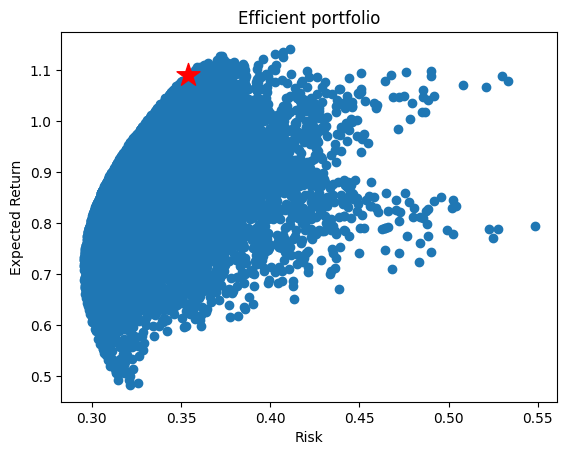

In [93]:
plt.scatter(data=port_df,x='Risk',y='Return')
plt.title('Efficient portfolio')
plt.xlabel('Risk')
plt.ylabel('Expected Return')
max_sharpe=port_df.loc[port_df['Sharpe']==port_df['Sharpe'].max()] #마킹하는 법(dataframe위 한 점 선택)
plt.scatter(x=max_sharpe['Risk'],y=max_sharpe['Return'],c='r',marker='*',s=300) #사이즈 지정필수
plt.show()

In [94]:
max_sharpe

,Return,Risk,Sharpe,셀트리온,LG전자,삼성전자,카카오
15019,1.089765,0.353953,3.064712,0.090438,0.016155,0.278603,0.614805


##2)볼린저밴드
실제로도 많이 쓰는 기법

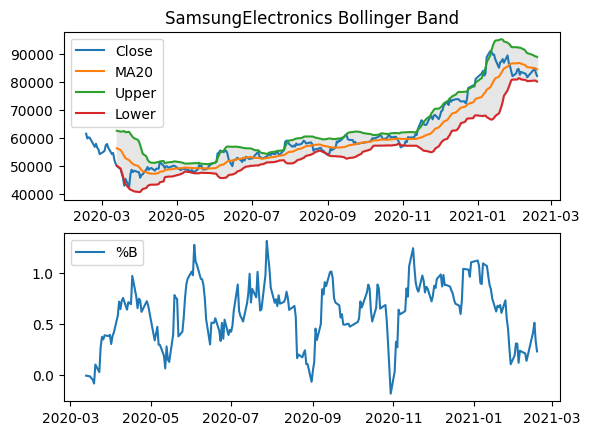

In [95]:
sm_df['MA20']=sm_df['Close'].rolling(window=20).mean() #이젠 너무 간단
sm_df['std']=sm_df.Close.rolling(window=20).std()
sm_df['Upper']=sm_df['MA20']+sm_df['std']*2 #MA20그리는 이유
sm_df['Lower']=sm_df['MA20']-sm_df['std']*2
sm_df['%B']=(sm_df['Close']-sm_df['Lower'])/(sm_df['Upper']-sm_df['Lower'])
plt.subplot(2,1,1)
plt.plot(sm_df.index,sm_df['Close'],label='Close') #x,y값좌표들을 찍음
plt.plot(sm_df.index,sm_df['MA20'],label='MA20')
plt.plot(sm_df.index,sm_df['Upper'],label='Upper')
plt.plot(sm_df.index,sm_df['Lower'],label='Lower')
plt.fill_between(sm_df.index,sm_df['Upper'],sm_df['Lower'],color='0.9') #볼린저밴드에 한정해서 외우기
plt.title('SamsungElectronics Bollinger Band')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(sm_df.index,sm_df['%B'],label='%B')
plt.legend(loc='best')

###1)흐름타기
MoneyFlow(Typical price에 거래량 가중치)<br>
%B와 MFI값 모두 80보다 높으면 매수<br>
%B와 MFI값 모두 20보다 낮으면 매도<br>

In [96]:
sm_df['%B']=100*(sm_df['Close']-sm_df['Lower'])/(sm_df['Upper']-sm_df['Lower'])
sm_df['TP']=(sm_df['High']+sm_df['Low']+sm_df['Close'])/3 #최고,최저,종가(Open빼고)
sm_df['PMF']=0
sm_df['NMF']=0
for i in range(len(sm_df.Close)-1):
  if sm_df.TP.values[i]<sm_df.TP.values[i+1]: #증가할때 리스트의 i+1번째 원소
     sm_df.PMF.values[i+1]=sm_df.TP.values[i+1]*sm_df.Volume.values[i+1]
     sm_df.NMF.values[i+1]=0 #둘다 동시입력(null값없게)
  else:
     sm_df.NMF.values[i+1]=sm_df.TP.values[i+1]*sm_df.Volume.values[i+1]
     sm_df.PMF.values[i+1]=0
sm_df['MF']=sm_df.PMF.rolling(window=10).sum()/sm_df.NMF.rolling(window=10).sum() #MF는 특정기간동안의 수치
sm_df['MFI10']=100-100/(1+sm_df['MF']) #공식 암기하기

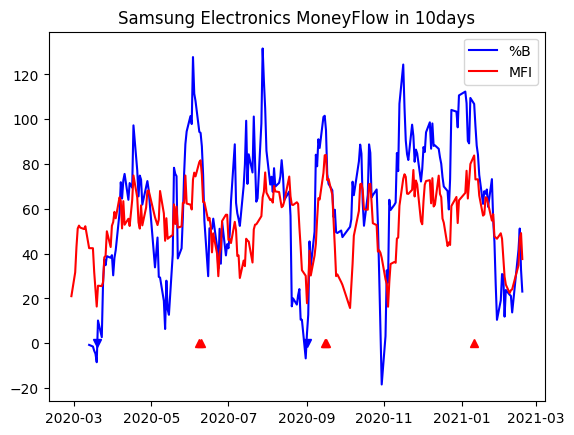

In [97]:
plt.plot(sm_df.index,sm_df['%B'],'b',label='%B')
plt.plot(sm_df.index,sm_df['MFI10'],'r',label='MFI')
for i in range(len(sm_df['Close'])):
  if sm_df['%B'].values[i]>80 and sm_df['MFI10'].values[i]>80:
    plt.plot(sm_df.index.values[i],0,'r^') #^v shows shape #index시리즈가 아니라 list의 i번째원소가 필요
  if sm_df['%B'].values[i]<20 and sm_df['MFI10'].values[i]<20:
    plt.plot(sm_df.index.values[i],0,'bv') 
plt.title('Samsung Electronics MoneyFlow in 10days')
plt.legend(loc='best')
plt.show()

###2)반전노리기
강도<br>
%B값 0.05보다 작고 %I 양수면 매수<br>
%B값 0.95보다 크고 %I 음수면 매도

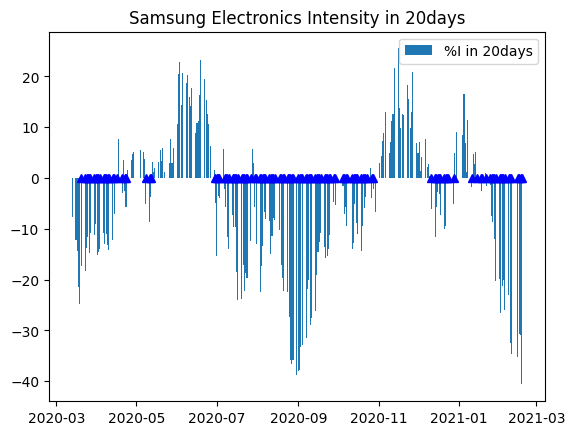

In [98]:
sm_df['Intensity']=sm_df['Volume']*(2*sm_df['Close']-sm_df['High']-sm_df['Low'])/(sm_df['High']-sm_df['Low'])
sm_df['%I']=100*sm_df['Intensity'].rolling(window=20).sum()/sm_df['Volume'].rolling(window=20).sum() #공식원리는 따로 공부해야할듯
sm_df.dropna()
plt.bar(sm_df.index,sm_df['%I'],label='%I in 20days')
for i in range(len(sm_df['Close'])):
  if sm_df['%B'].values[i]<0.05 and sm_df['%I'].values[i]>0:
    plt.plot(sm_df.index.values[i],0,'r^')
  elif sm_df['%B'].values[i]>0.95 and sm_df['%I'].values[i]<0:
    plt.plot(sm_df.index.values[i],0,'b^')
plt.title('Samsung Electronics Intensity in 20days')
plt.legend(loc='best')
plt.show()

##3)삼중창매매<br>
MarketTide,MarketWave,EntryTechnique<br>
MACD히스토그램이 나타내는 추세와 스토캐스틱이 나타내는 변동이<br>
상반된 신호 보낼 수 있으므로 상호보완적 시도

###1)흐름타기
MACD히스토그램값 음수에서 증가중이면 매수<br>
MACD히스토그램값 양수에서 감소중이면 매도

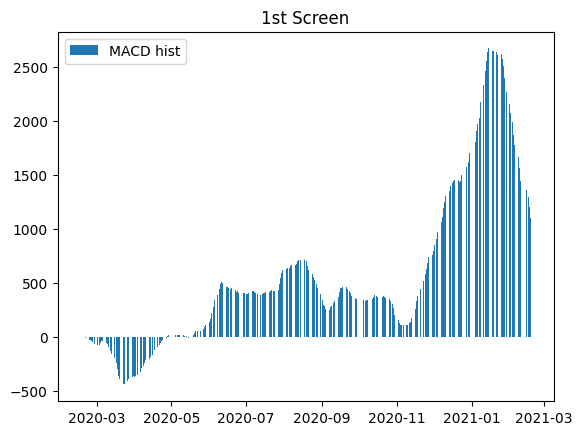

In [99]:
EMA60=sm_df['Close'].ewm(span=60).mean() #pandas에서 exponentially weighted 함수 내장 #1Q,2Q
EMA130=sm_df['Close'].ewm(span=130).mean()
macd=ema60-ema130
signal=macd.ewm(span=45).mean() #macd로 ewm 또 한번
macdhist=macd-signal #macd보다 히스토그램이 더 중요
plt.bar(sm_df.index,macdhist,label='MACD hist') #histogram이니까
plt.title('1st Screen')
plt.legend(loc='best')

###2)반전노리기
%D는 더 적게 신호보내기에 좀 더 정확<br>
%K 30보다 작으면 매수<br>
%K 70보다 작으면 매수<br>

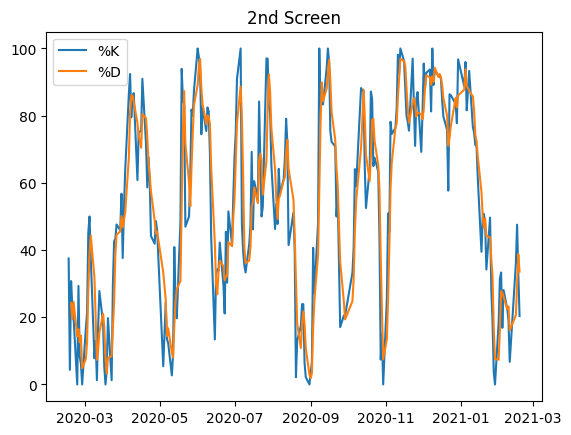

In [100]:
L14=sm_df.Low.rolling(window=14,min_periods=1).min() #min_periods필수
H14=sm_df.High.rolling(window=14,min_periods=1).max()
sm_df['%K']=100*(sm_df['Close']-L14)/(H14-L14)
sm_df['%D']=sm_df['%K'].rolling(window=3).mean() #평활화 공식하고 다른데 어쩔수 없는건가
plt.plot(sm_df.index,sm_df['%K'],label='%K')
plt.plot(sm_df.index,sm_df['%D'],label='%D')
plt.title('2nd Screen')
plt.legend(loc='best')

Text(0.5, 1.0, '3rd Screen')

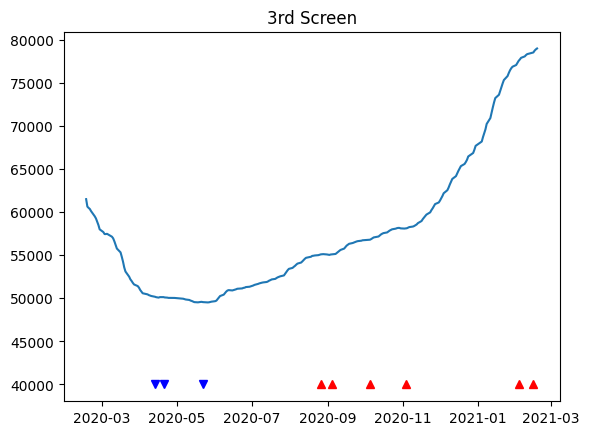

In [119]:
plt.plot(sm_df.index,EMA60,label=EMA60)
for i in range(len(sm_df)):
  if EMA60.values[i-1]<EMA60.values[i] and sm_df['%D'].values[i-1]<=20 and sm_df['%D'].values[i]>20: #상향돌파
    plt.plot(sm_df.index[i],40000,'r^')
  elif EMA60.values[i-1]>=EMA60.values[i] and sm_df['%D'].values[i-1]>=80 and sm_df['%D'].values[i]<80: #하향돌파
    plt.plot(sm_df.index[i],40000,'bv')
plt.title('3rd Screen')

##4)듀얼모멘텀
흐름타기의 끝판왕<br>
상투잡게 될 위험이 커보이므로 보류<br>
